#Pythonize AMBER suite

In [63]:
%matplotlib inline

In [64]:
%config InlineBackend.figure_format = 'retina'  # high resolution
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi'] # larger image
from matplotlib import pyplot as plt

In [65]:
import pytraj
import sander
from pytraj import io as mdio

#Pytraj

##post processing trajectory with pysander and pytraj

[-466.10420332687943, -455.5976464241175, -448.8931420795517, -450.3030628951594, -443.75073691232376]


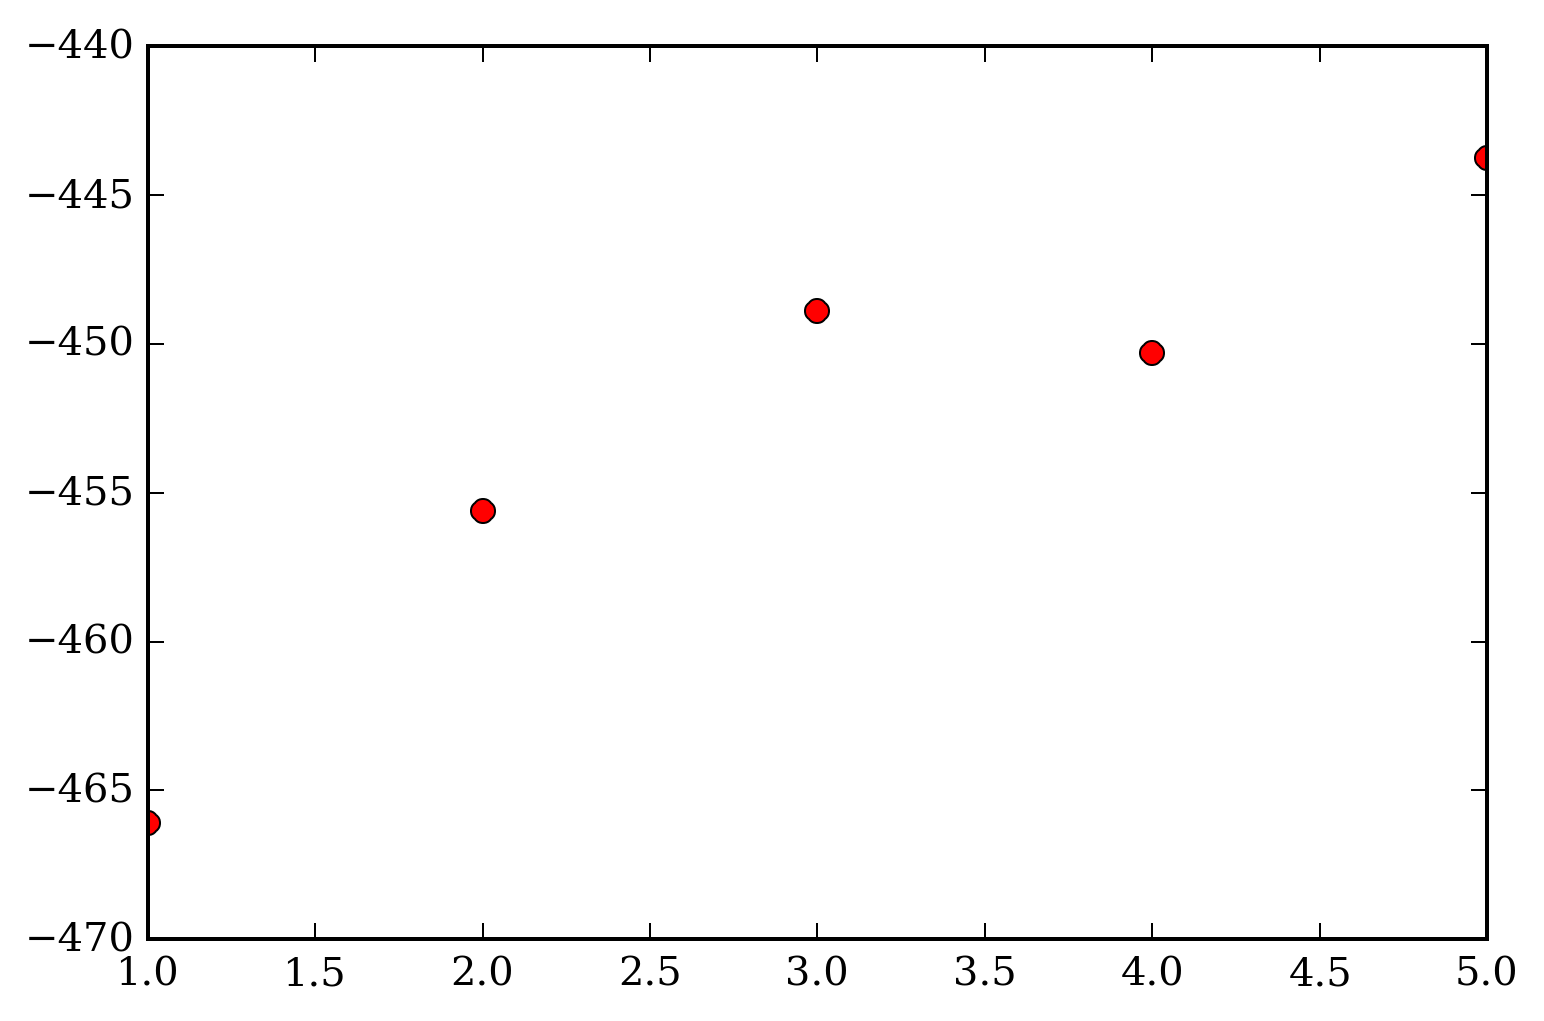

In [66]:
from chemistry.amber.readparm import AmberParm

traj_fn = "../../tests/data/md1_prod.Tc5b.x"
top_fn = "../../tests/data/Tc5b.top"

# load parm from `chemistry` package
parm = AmberParm(top_fn)

# load  traj from `pytraj`
# load traj
traj = mdio.load(traj_fn, top_fn)

# initialize parm
parm.load_coordinates(traj[0].coords)

# create input for igb=8 model
inp = sander.gas_input(8)

egb = []
with sander.setup(parm, parm.coords, None, inp):
    # use traj(0, 8, 2) to read the traj from 0-th frame to 8-th frame but skiping every 2 frames
    for frame in traj(0, 8, 2):
        sander.set_positions(frame.coords)
        ene, forces = sander.energy_forces()
        
        # get GB energies
        egb.append(ene.gb)
        
# plotting
print (egb)
x_axis = [i+1 for i in range(len(egb))]
plt.plot(x_axis, egb, 'ro')

##easy to extract coordinates of specific mask

In [67]:
traj[':1-5@CA'][:2]

array([[[-17.146,  12.069,  -9.756],
        [-15.774,   9.648,  -7.087],
        [-16.761,   7.688,  -3.829],
        [-15.228,   5.335,  -1.254],
        [-15.974,   4.229,   2.418]],

       [[  7.385,  -5.506,  -7.819],
        [  3.762,  -4.45 ,  -8.505],
        [  2.361,  -1.019,  -9.706],
        [  0.106,  -0.595,  -6.613],
        [  1.738,  -0.631,  -3.015]]])

##easy to strip atoms

In [68]:
traj[':1-5@CA :frame'][:2]

FrameArray instance with 2 frames, 5 atoms/frame
           

##easy to combine with `pandas`

In [69]:
from pytraj import calculate
from pytraj.dataframe import to_dataframe
import pandas as pd
pd.set_option('precision', 2)

d0 = calculate('multidihedral', 'phi psi resrange 6-9', traj)
dframe = to_dataframe(d0)
dframe

,phi:6,phi:7,phi:8,phi:9,psi:6,psi:7,psi:8,psi:9
0,-154.4,-163.6,-133.7,-100.6,162.6,128.3,121.3,128.3
1,-148.6,-146.4,-60.9,-132.7,136.1,123.3,-53.7,153.4
2,-131.4,-113.7,-73.3,-133.2,134.0,-168.5,-27.0,91.0
3,-82.6,-134.3,-88.2,-153.3,101.1,145.7,-9.2,143.0
4,-74.3,-108.6,-76.7,-63.4,84.6,-173.8,-28.5,117.8
5,-110.5,-128.0,-84.9,-108.5,130.9,150.4,-34.7,119.0
6,-102.6,-122.5,-87.2,-144.6,131.7,144.4,61.4,123.6
7,-140.0,-113.7,-87.8,-158.9,122.8,148.5,85.6,151.8
8,-68.4,-140.5,-100.0,-115.1,135.5,161.1,48.6,157.9
9,-104.8,-137.7,-91.9,-117.1,136.5,146.6,57.8,168.7


In [70]:
dframe[1:5].transpose()

,1,2,3,4
phi:6,-148.6,-131.4,-82.6,-74.3
phi:7,-146.4,-113.7,-134.3,-108.6
phi:8,-60.9,-73.3,-88.2,-76.7
phi:9,-132.7,-133.2,-153.3,-63.4
psi:6,136.1,134.0,101.1,84.6
psi:7,123.3,-168.5,145.7,-173.8
psi:8,-53.7,-27.0,-9.2,-28.5
psi:9,153.4,91.0,143.0,117.8


In [81]:
res= traj.top.residuelist[5]
print (res)
print (res.n_atoms)
print (traj.top[':6']) # need to have prettier printing, better to use `parmed`

TRP -5
24
[<N    - resnum 5>, <H    - resnum 5>, <CA   - resnum 5>, <HA   - resnum 5>, <CB   - resnum 5>, <HB2  - resnum 5>, <HB3  - resnum 5>, <CG   - resnum 5>, <CD1  - resnum 5>, <HD1  - resnum 5>, <NE1  - resnum 5>, <HE1  - resnum 5>, <CE2  - resnum 5>, <CZ2  - resnum 5>, <HZ2  - resnum 5>, <CH2  - resnum 5>, <HH2  - resnum 5>, <CZ3  - resnum 5>, <HZ3  - resnum 5>, <CE3  - resnum 5>, <HE3  - resnum 5>, <CD2  - resnum 5>, <C    - resnum 5>, <O    - resnum 5>]


##easy to 'talk' to other package: mdtraj

FrameArray instance with 501 frames, 22 atoms/frame
           
['Mat_00000', 'Mat_00000[ByRes]']


(<matplotlib.figure.Figure at 0x2aaaedea78d0>,
 <matplotlib.image.AxesImage at 0x2aaaee3cee80>)

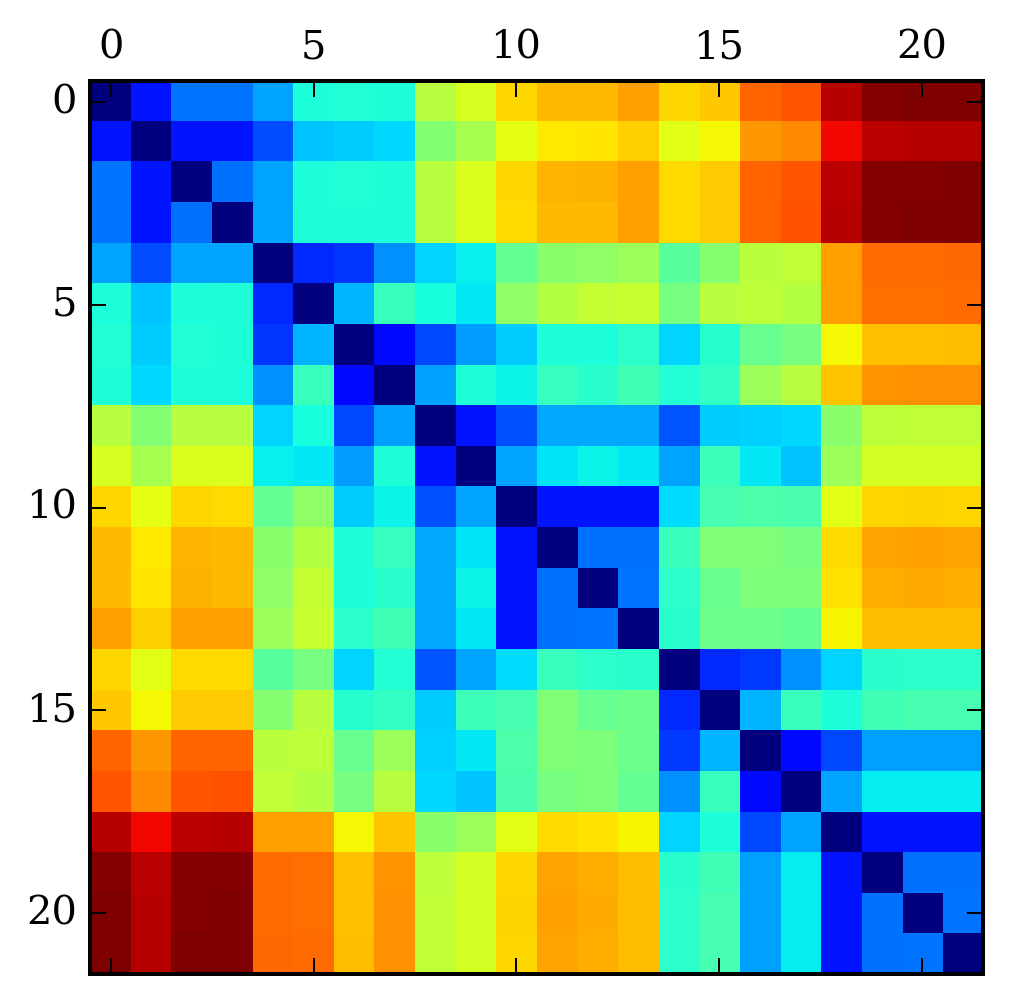

In [71]:
import mdtraj as md
import mdtraj.testing
from pytraj.load_mdtraj import load_mdtraj
from pytraj import DataSetList
dslist = DataSetList()

traj_filename = mdtraj.testing.get_fn('frame0.h5')
# load mdtraj trajectory object
m_traj = md.load(traj_filename)

# expose to `pytraj`
my_traj = load_mdtraj(m_traj)
print (my_traj)

calculate("matrix", "byres", my_traj, dslist=dslist)
from pytraj.plots import plot_matrix
print (dslist.get_legends())
plot_matrix(dslist[0])

##easy to 'talk' to other package: numpy

In [84]:
import numpy as np

frame = traj[0]

arr0 = np.asarray(frame[:])
print (frame.shape)
print (arr0.shape)

# change x-coord of all atoms to 0.0 (dummy example)
arr0[:, 0] = np.zeros(traj.n_atoms)
print (frame[:, 0])

(304, 3)
(304, 3)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. 

##easy to construct Trajectory and save to different file formats

In [72]:
from pytraj import FrameArray

# load xyz coordinates from ParmEd package
frame_array = FrameArray(parm.coords, traj.top)
frame_array.save("my_charmming.dcd")

In [73]:
!ls my_charmming.dcdb

ls: my_charmming.dcdb: No such file or directory


#Future

###this code does not exist yet (it's really **hurt** to try)

    import nab
    from pmemd import run_min_gpu
    import leap

    frame = nab.build_nu(sequence="GCGC", build_type='dna double')
    top = leap.build_top(frame, forcefield='bsc0')
    new_frame = run_min_gpu(frame)